# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses


In this notebook, we are going to add this data to our dateset (1985 to 2018) to see if this behaves the same as our (1998 to 2018) dataset. I am picking this data because matchup_diff did the best out of all variations of historical data we picked when we ran this against our (1998 to 2018) dataset. If it does, our model performance should drop slightly.

Data that we obtained for each player:

* p1_matchup_wins_diff = p1_matchup_wins - p2_matchup_wins
* p1_matchup_games_diff = p1_matchup_games (won) - p2_matchup_games (won)
* p1_matchup_sets_diff = p1_matchup_sets (won) - p2_matchup_sets (won)

We will see if this data helps improve our models

### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features (1985 to 2018):

```
Model Score: 0.9404228058936579

ROC/AUC Score: 0.9404009956149442
              precision    recall  f1-score   support

        Loss       0.94      0.95      0.94     12536
         Win       0.95      0.93      0.94     12440

    accuracy                           0.94     24976
   macro avg       0.94      0.94      0.94     24976
weighted avg       0.94      0.94      0.94     24976
```

# Summary of Results

Actually, we are seeing a slight increase in accuracy (~0.1%). Without further inspection, it's hard to tell but this is probably not significant. Given that creating to level of effort to create matchup diff data for each match, for this type of improvement, it's probably not worth the extra features and time to create the features.

```
Model Score: 0.9405429212043562

ROC/AUC Score: 0.9405252679357404
              precision    recall  f1-score   support

        Loss       0.94      0.95      0.94     12536
         Win       0.94      0.94      0.94     12440

    accuracy                           0.94     24976
   macro avg       0.94      0.94      0.94     24976
weighted avg       0.94      0.94      0.94     24976
```




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup_diff-1985"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1985
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all columns that doesn't have diff
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('diff', col)]
    data = data.drop(matchup_columns, axis=1)

    print(f'After: data.shape {data.shape}')
    
    return data
    
X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (74925, 5293)
After: data.shape (74925, 5254)
Before: data.shape (24976, 5293)
After: data.shape (24976, 5254)


In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games_diff', 'p1_matchup_sets_diff', 'p1_matchup_wins_diff']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6647581678411275

ROC/AUC Score: 0.6647610636992471
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.67     12536
         Win       0.66      0.67      0.66     12440

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8324  4212
Win   4161  8279


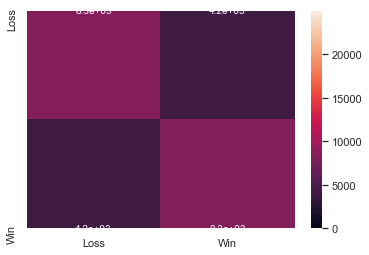

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8292761050608585

ROC/AUC Score: 0.829210176941213
              precision    recall  f1-score   support

        Loss       0.82      0.85      0.83     12536
         Win       0.84      0.81      0.83     12440

    accuracy                           0.83     24976
   macro avg       0.83      0.83      0.83     24976
weighted avg       0.83      0.83      0.83     24976

       Loss    Win
Loss  10610   1926
Win    2338  10102


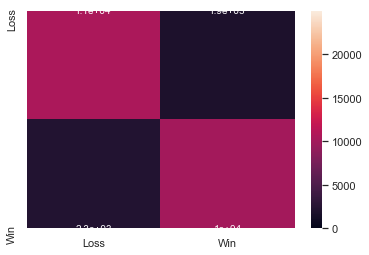

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9405429212043562

ROC/AUC Score: 0.9405252679357404
              precision    recall  f1-score   support

        Loss       0.94      0.95      0.94     12536
         Win       0.94      0.94      0.94     12440

    accuracy                           0.94     24976
   macro avg       0.94      0.94      0.94     24976
weighted avg       0.94      0.94      0.94     24976

       Loss    Win
Loss  11848    688
Win     797  11643


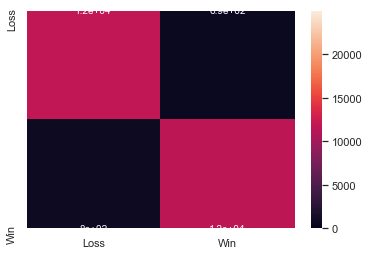

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Model Score: 0.7848334401024984

ROC/AUC Score: 0.7846800571267932
              precision    recall  f1-score   support

        Loss       0.77      0.82      0.79     12536
         Win       0.81      0.74      0.78     12440

    accuracy                           0.78     24976
   macro avg       0.79      0.78      0.78     24976
weighted avg       0.79      0.78      0.78     24976

       Loss   Win
Loss  10337  2199
Win    3175  9265


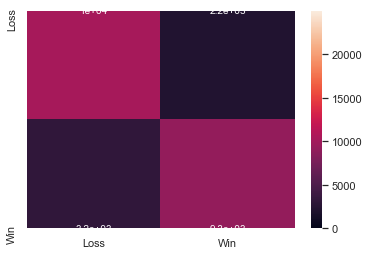

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3181           34.08m
         2           1.2625           30.06m
         3           1.2162           28.21m
         4           1.1794           27.22m
         5           1.1486           26.69m
         6           1.1216           26.13m
         7           1.0915           26.34m
         8           1.0720           26.35m
         9           1.0483           26.11m
        10           1.0279           25.99m
        20           0.9040           21.75m
        30           0.8425           18.33m
        40           0.7998           15.36m
        50           0.7712           13.01m
        60           0.7495           10.51m
        70           0.7277            7.99m
        80           0.7109            5.42m
        90           0.6972            2.72m
       100           0.6846            0.00s


Model Score: 0.8581838565022422

ROC/AUC Score: 0.8580795732727045
              precision    recall  f1-score   support

        Loss       0.84      0.89      0.86     12536
         Win       0.88      0.83      0.85     12440

    accuracy                           0.86     24976
   macro avg       0.86      0.86      0.86     24976
weighted avg       0.86      0.86      0.86     24976

       Loss    Win
Loss  11097   1439
Win    2103  10337


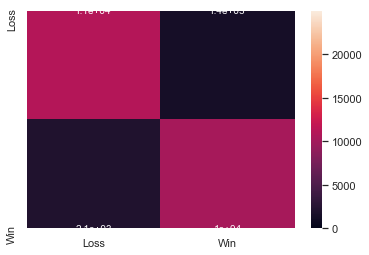

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7523222293401666

ROC/AUC Score: 0.7521957598130247
              precision    recall  f1-score   support

        Loss       0.74      0.79      0.76     12536
         Win       0.77      0.72      0.74     12440

    accuracy                           0.75     24976
   macro avg       0.75      0.75      0.75     24976
weighted avg       0.75      0.75      0.75     24976

      Loss   Win
Loss  9842  2694
Win   3492  8948


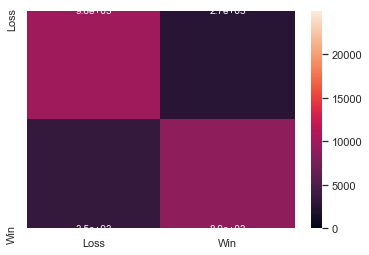

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results


In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
97,KNeighborsClassifier,diff-ohe-matchup_diff-1985,../datasets/atp_matches_1985-2019_features-dif...,1985,2018,0.829276,0.829210,"{""0"": {""0"": 10610, ""1"": 2338}, ""1"": {""0"": 1926...","{""Loss"": {""precision"": 0.8194315724436206, ""re...",../models/kneighborsclassifier-1985-2018-diff-...,1.0,0.0,1.0
98,DecisionTreeClassifier,diff-ohe-matchup_diff-1985,../datasets/atp_matches_1985-2019_features-dif...,1985,2018,0.940543,0.940525,"{""0"": {""0"": 11848, ""1"": 797}, ""1"": {""0"": 688, ...","{""Loss"": {""precision"": 0.9369711348359036, ""re...",../models/decisiontreeclassifier-1985-2018-dif...,0.0,0.0,0.0
99,RandomForestClassifier,diff-ohe-matchup_diff-1985,../datasets/atp_matches_1985-2019_features-dif...,1985,2018,0.784833,0.784680,"{""0"": {""0"": 10337, ""1"": 3175}, ""1"": {""0"": 2199...","{""Loss"": {""precision"": 0.7650236826524571, ""re...",../models/randomforestclassifier-1985-2018-dif...,0.0,0.0,0.0
100,GradientBoostingClassifier,diff-ohe-matchup_diff-1985,../datasets/atp_matches_1985-2019_features-dif...,1985,2018,0.858184,0.858080,"{""0"": {""0"": 11097, ""1"": 2103}, ""1"": {""0"": 1439...","{""Loss"": {""precision"": 0.8406818181818182, ""re...",../models/gradientboostingclassifier-1985-2018...,0.0,27.0,27.0
101,AdaBoostClassifier,diff-ohe-matchup_diff-1985,../datasets/atp_matches_1985-2019_features-dif...,1985,2018,0.752322,0.752196,"{""0"": {""0"": 9842, ""1"": 3492}, ""1"": {""0"": 2694,...","{""Loss"": {""precision"": 0.7381130943452827, ""re...",../models/adaboostclassifier-1985-2018-diff-oh...,0.0,2.0,2.0


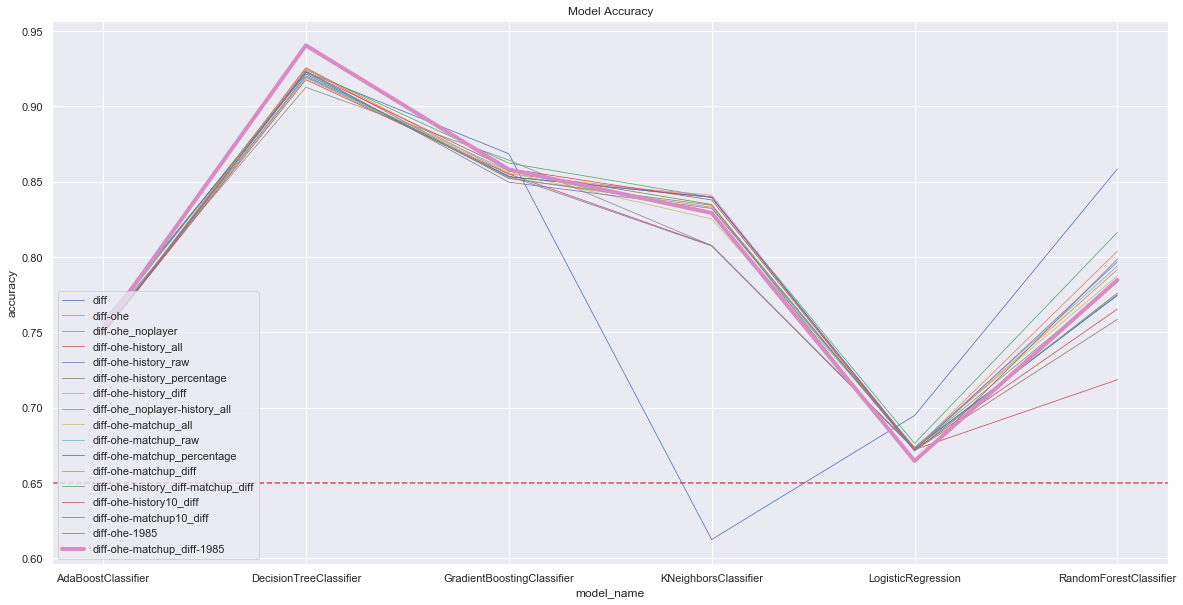

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

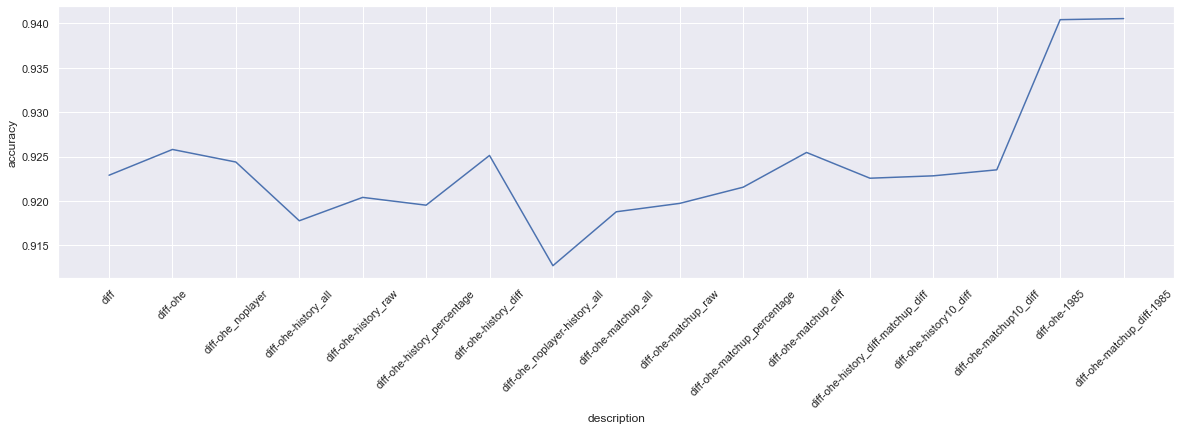

In [31]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
import shap

shap.initjs()

mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)



(2, 24976, 5254)


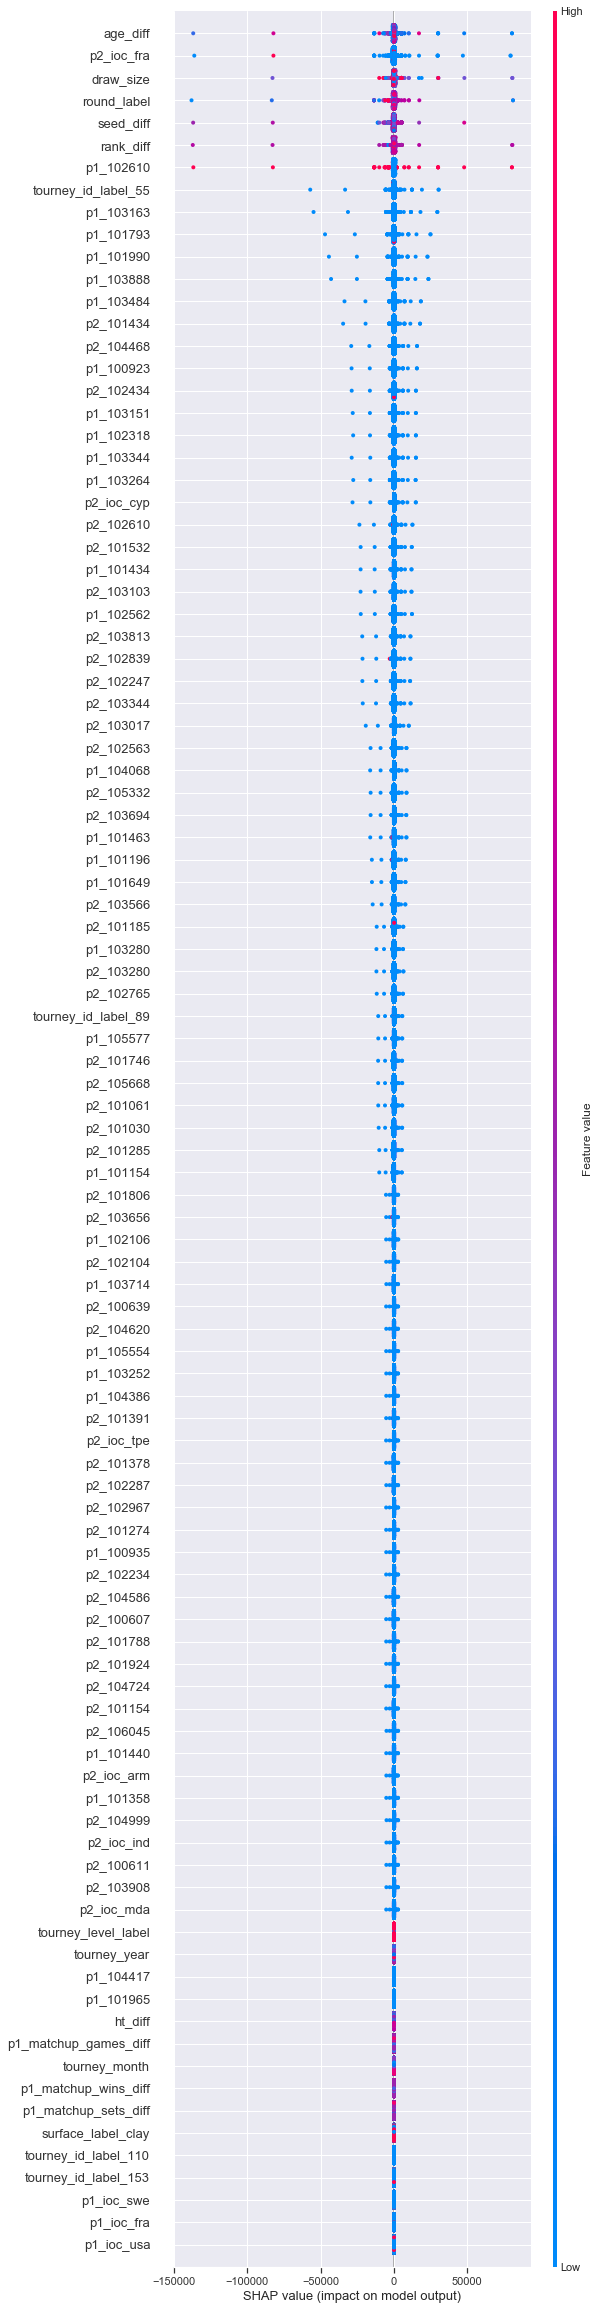

In [33]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=100)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, title="Feature Importance")